In [2]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense,Embedding,Input,LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam,SGD

In [3]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS =2000
LATENT_DIM = 25

In [7]:
# load the data
input_texts = []
target_texts = []
for line in open('robert_frost.txt'):
    line = line.rstrip()
    if not line:
        continue
    
    input_line = '<sos> '+line
    target_line = line + ' <eos>'
    
    input_texts.append(input_line)
    target_texts.append(target_line)
all_lines = input_texts + target_texts

#convert the sentences(string) into integers
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE, filters = '')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [8]:
# find max seq length
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length:',max_sequence_length_from_data)

Max sequence length: 12


In [9]:
# get word -> integer amapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.'%len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3056 unique tokens.


In [10]:
# pad sequences to get N*T matrix
max_sequence_length = min(max_sequence_length_from_data,MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences,maxlen=max_sequence_length,padding='post')
target_sequences = pad_sequences(target_sequences,maxlen=max_sequence_length,padding='post')
print('Shape of data tensor:',input_sequences.shape)

Shape of data tensor: (1436, 12)


In [13]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove.6B/glove.6B.%sd.txt' %EMBEDDING_DIM),encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:],dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.'%len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [14]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words =  min(MAX_VOCAB_SIZE,len(word2idx)+1)
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for word,i in word2idx.items():
    if i<MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # word not foi=und in the embedding index  will be all zero
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [17]:
# one hot the targets
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length,num_words))
for i, target_sequences in enumerate(target_sequences):
    for t, word in enumerate(target_sequences):
        if word>0:
            one_hot_targets[i,t,word] = 1

In [18]:
# load pre trained word embeddings into an embedding layers
embedding_layer = Embedding(
num_words,
EMBEDDING_DIM,
weights = [embedding_matrix],
# trainable = False
)

In [19]:
print('Building Model.....')
# create an LSTM network with a single LSTM
input_ = Input(shape = (max_sequence_length,))
initial_h = Input(shape = (LATENT_DIM,))
initial_c = Input(shape = (LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM,return_sequences=True,return_state=True)
x,_,_ = lstm(x,initial_state = [initial_h,initial_c])
dense = Dense(num_words, activation = 'softmax')
output = dense(x)

Building Model.....






In [20]:
model = Model([input_,initial_h,initial_c],output)
model.compile(
loss = 'categorical_crossentropy',
optimizer = Adam(lr = 0.01),
metrics = ['accuracy'])

In [22]:
print('Training model ........')
z = np.zeros((len(input_sequences),LATENT_DIM))
r = model.fit(
[input_sequences,z,z],
one_hot_targets,
batch_size = BATCH_SIZE,
epochs=EPOCHS,
validation_split=VALIDATION_SPLIT
)

Training model ........
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1148 samples, validate on 288 samples
Epoch 1/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 5.3681 - acc: 0.0118 - val_loss: 5.0280 - val_acc: 0.0177
Epoch 2/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 4.6028 - acc: 0.0459 - val_loss: 4.8345 - val_acc: 0.0833
Epoch 3/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 4.3871 - acc: 0.0833 - val_loss: 4.9511 - val_acc: 0.0833
Epoch 4/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 4.3265 - acc: 0.0833 - val_loss: 4.9721 - val_acc: 0.0833
Epoch 5/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 4.2950 - acc: 0.0833 - val_loss: 5.0061 - val_acc: 0.0833
Epoch 6/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 4.2730 - acc: 0.0833 - val_loss: 5.0084 - val_acc: 0.0833
Epoch 7/2000
1148/1

1148/1148 [==============================] - 2s 2ms/step - loss: 2.7684 - acc: 0.2006 - val_loss: 5.1479 - val_acc: 0.0937
Epoch 58/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 2.7494 - acc: 0.2005 - val_loss: 5.1540 - val_acc: 0.0932
Epoch 59/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.7319 - acc: 0.2043 - val_loss: 5.1691 - val_acc: 0.0911
Epoch 60/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.7149 - acc: 0.2066 - val_loss: 5.1770 - val_acc: 0.0911
Epoch 61/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.6974 - acc: 0.2089 - val_loss: 5.1840 - val_acc: 0.0900
Epoch 62/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 2.6821 - acc: 0.2109 - val_loss: 5.1925 - val_acc: 0.0932
Epoch 63/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 2.6654 - acc: 0.2142 - val_loss: 5.2027 - val_acc: 0.0897
Epoch 64/2000
1148/1148 [==============================

Epoch 117/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.1048 - acc: 0.2781 - val_loss: 5.5894 - val_acc: 0.0807
Epoch 118/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.0977 - acc: 0.2777 - val_loss: 5.5996 - val_acc: 0.0802
Epoch 119/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.0908 - acc: 0.2782 - val_loss: 5.6086 - val_acc: 0.0781
Epoch 120/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.0855 - acc: 0.2809 - val_loss: 5.6114 - val_acc: 0.0802
Epoch 121/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.0775 - acc: 0.2804 - val_loss: 5.6131 - val_acc: 0.0804
Epoch 122/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.0691 - acc: 0.2814 - val_loss: 5.6241 - val_acc: 0.0778
Epoch 123/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 2.0617 - acc: 0.2836 - val_loss: 5.6350 - val_acc: 0.0787
Epoch 124/2000
1148/1148 [========

1148/1148 [==============================] - 3s 2ms/step - loss: 1.7696 - acc: 0.3266 - val_loss: 5.9401 - val_acc: 0.0735
Epoch 177/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.7643 - acc: 0.3274 - val_loss: 5.9416 - val_acc: 0.0732
Epoch 178/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.7596 - acc: 0.3291 - val_loss: 5.9450 - val_acc: 0.0738
Epoch 179/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.7555 - acc: 0.3298 - val_loss: 5.9461 - val_acc: 0.0752
Epoch 180/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.7529 - acc: 0.3300 - val_loss: 5.9588 - val_acc: 0.0729
Epoch 181/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.7499 - acc: 0.3312 - val_loss: 5.9593 - val_acc: 0.0729
Epoch 182/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.7437 - acc: 0.3305 - val_loss: 5.9658 - val_acc: 0.0749
Epoch 183/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.5539 - acc: 0.3648 - val_loss: 6.2256 - val_acc: 0.0732
Epoch 236/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.5516 - acc: 0.3651 - val_loss: 6.2331 - val_acc: 0.0726
Epoch 237/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.5463 - acc: 0.3684 - val_loss: 6.2447 - val_acc: 0.0726
Epoch 238/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.5426 - acc: 0.3677 - val_loss: 6.2476 - val_acc: 0.0735
Epoch 239/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.5404 - acc: 0.3677 - val_loss: 6.2513 - val_acc: 0.0720
Epoch 240/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.5384 - acc: 0.3696 - val_loss: 6.2522 - val_acc: 0.0720
Epoch 241/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.5345 - acc: 0.3685 - val_loss: 6.2529 - val_acc: 0.0732
Epoch 242/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.4045 - acc: 0.3931 - val_loss: 6.4542 - val_acc: 0.0689
Epoch 295/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.4020 - acc: 0.3944 - val_loss: 6.4648 - val_acc: 0.0686
Epoch 296/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.4013 - acc: 0.3942 - val_loss: 6.4558 - val_acc: 0.0694
Epoch 297/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.3971 - acc: 0.3950 - val_loss: 6.4560 - val_acc: 0.0689
Epoch 298/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.3961 - acc: 0.3953 - val_loss: 6.4744 - val_acc: 0.0692
Epoch 299/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.3929 - acc: 0.3940 - val_loss: 6.4703 - val_acc: 0.0709
Epoch 300/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.3905 - acc: 0.3951 - val_loss: 6.4793 - val_acc: 0.0694
Epoch 301/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.2898 - acc: 0.4161 - val_loss: 6.6604 - val_acc: 0.0697
Epoch 354/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2884 - acc: 0.4172 - val_loss: 6.6664 - val_acc: 0.0668
Epoch 355/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2862 - acc: 0.4183 - val_loss: 6.6758 - val_acc: 0.0692
Epoch 356/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2834 - acc: 0.4172 - val_loss: 6.6709 - val_acc: 0.0692
Epoch 357/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2819 - acc: 0.4182 - val_loss: 6.6818 - val_acc: 0.0689
Epoch 358/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2802 - acc: 0.4202 - val_loss: 6.6940 - val_acc: 0.0674
Epoch 359/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2791 - acc: 0.4200 - val_loss: 6.6908 - val_acc: 0.0689
Epoch 360/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.2173 - acc: 0.4329 - val_loss: 6.8759 - val_acc: 0.0639
Epoch 413/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2114 - acc: 0.4339 - val_loss: 6.8637 - val_acc: 0.0637
Epoch 414/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2145 - acc: 0.4328 - val_loss: 6.8659 - val_acc: 0.0628
Epoch 415/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2120 - acc: 0.4330 - val_loss: 6.8663 - val_acc: 0.0628
Epoch 416/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2088 - acc: 0.4351 - val_loss: 6.8607 - val_acc: 0.0648
Epoch 417/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2070 - acc: 0.4357 - val_loss: 6.8841 - val_acc: 0.0616
Epoch 418/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.2025 - acc: 0.4361 - val_loss: 6.8717 - val_acc: 0.0637
Epoch 419/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.1430 - acc: 0.4464 - val_loss: 7.0047 - val_acc: 0.0602
Epoch 472/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.1404 - acc: 0.4495 - val_loss: 7.0158 - val_acc: 0.0605
Epoch 473/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.1430 - acc: 0.4471 - val_loss: 7.0146 - val_acc: 0.0611
Epoch 474/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.1378 - acc: 0.4503 - val_loss: 7.0292 - val_acc: 0.0605
Epoch 475/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.1347 - acc: 0.4520 - val_loss: 7.0091 - val_acc: 0.0611
Epoch 476/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.1336 - acc: 0.4478 - val_loss: 7.0331 - val_acc: 0.0596
Epoch 477/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.1321 - acc: 0.4500 - val_loss: 7.0137 - val_acc: 0.0611
Epoch 478/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.0834 - acc: 0.4625 - val_loss: 7.1432 - val_acc: 0.0579
Epoch 531/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0871 - acc: 0.4584 - val_loss: 7.1296 - val_acc: 0.0622
Epoch 532/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0896 - acc: 0.4605 - val_loss: 7.1337 - val_acc: 0.0593
Epoch 533/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0905 - acc: 0.4601 - val_loss: 7.1388 - val_acc: 0.0628
Epoch 534/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0905 - acc: 0.4589 - val_loss: 7.1383 - val_acc: 0.0613
Epoch 535/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0917 - acc: 0.4578 - val_loss: 7.1442 - val_acc: 0.0613
Epoch 536/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0904 - acc: 0.4586 - val_loss: 7.1338 - val_acc: 0.0619
Epoch 537/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.0401 - acc: 0.4709 - val_loss: 7.2640 - val_acc: 0.0570
Epoch 590/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0381 - acc: 0.4728 - val_loss: 7.2525 - val_acc: 0.0608
Epoch 591/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0364 - acc: 0.4734 - val_loss: 7.2655 - val_acc: 0.0584
Epoch 592/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0359 - acc: 0.4746 - val_loss: 7.2590 - val_acc: 0.0602
Epoch 593/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0359 - acc: 0.4742 - val_loss: 7.2704 - val_acc: 0.0593
Epoch 594/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0316 - acc: 0.4755 - val_loss: 7.2764 - val_acc: 0.0599
Epoch 595/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0303 - acc: 0.4760 - val_loss: 7.2703 - val_acc: 0.0593
Epoch 596/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 1.0025 - acc: 0.4810 - val_loss: 7.3819 - val_acc: 0.0602
Epoch 649/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9996 - acc: 0.4805 - val_loss: 7.3899 - val_acc: 0.0584
Epoch 650/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9976 - acc: 0.4805 - val_loss: 7.3732 - val_acc: 0.0602
Epoch 651/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9966 - acc: 0.4818 - val_loss: 7.3939 - val_acc: 0.0593
Epoch 652/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9961 - acc: 0.4818 - val_loss: 7.3778 - val_acc: 0.0605
Epoch 653/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9987 - acc: 0.4806 - val_loss: 7.4003 - val_acc: 0.0590
Epoch 654/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.0024 - acc: 0.4797 - val_loss: 7.4103 - val_acc: 0.0582
Epoch 655/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.9714 - acc: 0.4864 - val_loss: 7.4673 - val_acc: 0.0608
Epoch 708/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9724 - acc: 0.4865 - val_loss: 7.4704 - val_acc: 0.0616
Epoch 709/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9719 - acc: 0.4866 - val_loss: 7.4717 - val_acc: 0.0619
Epoch 710/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9710 - acc: 0.4853 - val_loss: 7.4718 - val_acc: 0.0616
Epoch 711/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9667 - acc: 0.4859 - val_loss: 7.4698 - val_acc: 0.0596
Epoch 712/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9644 - acc: 0.4887 - val_loss: 7.4755 - val_acc: 0.0605
Epoch 713/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9634 - acc: 0.4877 - val_loss: 7.4733 - val_acc: 0.0602
Epoch 714/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.9522 - acc: 0.4895 - val_loss: 7.5460 - val_acc: 0.0599
Epoch 767/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9493 - acc: 0.4893 - val_loss: 7.5414 - val_acc: 0.0616
Epoch 768/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9473 - acc: 0.4907 - val_loss: 7.5611 - val_acc: 0.0619
Epoch 769/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9458 - acc: 0.4911 - val_loss: 7.5507 - val_acc: 0.0628
Epoch 770/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9470 - acc: 0.4904 - val_loss: 7.5558 - val_acc: 0.0602
Epoch 771/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9469 - acc: 0.4911 - val_loss: 7.5605 - val_acc: 0.0616
Epoch 772/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9470 - acc: 0.4905 - val_loss: 7.5747 - val_acc: 0.0613
Epoch 773/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.9334 - acc: 0.4915 - val_loss: 7.6687 - val_acc: 0.0587
Epoch 826/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9339 - acc: 0.4926 - val_loss: 7.6575 - val_acc: 0.0582
Epoch 827/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9342 - acc: 0.4932 - val_loss: 7.6486 - val_acc: 0.0587
Epoch 828/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9298 - acc: 0.4935 - val_loss: 7.6578 - val_acc: 0.0587
Epoch 829/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9284 - acc: 0.4946 - val_loss: 7.6776 - val_acc: 0.0582
Epoch 830/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9298 - acc: 0.4922 - val_loss: 7.6761 - val_acc: 0.0584
Epoch 831/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9268 - acc: 0.4964 - val_loss: 7.6630 - val_acc: 0.0584
Epoch 832/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.9059 - acc: 0.4999 - val_loss: 7.7463 - val_acc: 0.0564
Epoch 885/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9039 - acc: 0.5005 - val_loss: 7.7381 - val_acc: 0.0573
Epoch 886/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9027 - acc: 0.4993 - val_loss: 7.7469 - val_acc: 0.0590
Epoch 887/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9032 - acc: 0.5009 - val_loss: 7.7521 - val_acc: 0.0587
Epoch 888/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9043 - acc: 0.4981 - val_loss: 7.7539 - val_acc: 0.0590
Epoch 889/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9029 - acc: 0.4995 - val_loss: 7.7560 - val_acc: 0.0590
Epoch 890/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.9020 - acc: 0.5000 - val_loss: 7.7505 - val_acc: 0.0605
Epoch 891/2000
1148/1148 [=======================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.8887 - acc: 0.5051 - val_loss: 7.7997 - val_acc: 0.0579
Epoch 944/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8906 - acc: 0.5033 - val_loss: 7.8181 - val_acc: 0.0587
Epoch 945/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8902 - acc: 0.5036 - val_loss: 7.8092 - val_acc: 0.0596
Epoch 946/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8877 - acc: 0.5043 - val_loss: 7.8072 - val_acc: 0.0587
Epoch 947/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8854 - acc: 0.5036 - val_loss: 7.8140 - val_acc: 0.0590
Epoch 948/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8845 - acc: 0.5051 - val_loss: 7.8262 - val_acc: 0.0596
Epoch 949/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8858 - acc: 0.5041 - val_loss: 7.8176 - val_acc: 0.0582
Epoch 950/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8856 - acc: 0.5034 - val_loss: 7.8798 - val_acc: 0.0573
Epoch 1003/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8865 - acc: 0.5021 - val_loss: 7.8734 - val_acc: 0.0587
Epoch 1004/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8854 - acc: 0.5040 - val_loss: 7.8707 - val_acc: 0.0590
Epoch 1005/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8835 - acc: 0.5046 - val_loss: 7.8575 - val_acc: 0.0590
Epoch 1006/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8821 - acc: 0.5049 - val_loss: 7.8758 - val_acc: 0.0587
Epoch 1007/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8771 - acc: 0.5057 - val_loss: 7.8936 - val_acc: 0.0567
Epoch 1008/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8796 - acc: 0.5053 - val_loss: 7.8784 - val_acc: 0.0573
Epoch 1009/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.8719 - acc: 0.5045 - val_loss: 7.9088 - val_acc: 0.0570
Epoch 1062/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8669 - acc: 0.5084 - val_loss: 7.9373 - val_acc: 0.0524
Epoch 1063/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8655 - acc: 0.5070 - val_loss: 7.9430 - val_acc: 0.0544
Epoch 1064/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8671 - acc: 0.5057 - val_loss: 7.9156 - val_acc: 0.0570
Epoch 1065/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8620 - acc: 0.5090 - val_loss: 7.9513 - val_acc: 0.0538
Epoch 1066/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8632 - acc: 0.5099 - val_loss: 7.9431 - val_acc: 0.0544
Epoch 1067/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8654 - acc: 0.5073 - val_loss: 7.9468 - val_acc: 0.0535
Epoch 1068/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.8677 - acc: 0.5065 - val_loss: 7.9794 - val_acc: 0.0532
Epoch 1121/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8625 - acc: 0.5079 - val_loss: 7.9914 - val_acc: 0.0550
Epoch 1122/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8603 - acc: 0.5103 - val_loss: 8.0010 - val_acc: 0.0570
Epoch 1123/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8572 - acc: 0.5083 - val_loss: 8.0051 - val_acc: 0.0538
Epoch 1124/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8590 - acc: 0.5088 - val_loss: 7.9942 - val_acc: 0.0532
Epoch 1125/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8551 - acc: 0.5095 - val_loss: 8.0126 - val_acc: 0.0544
Epoch 1126/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8528 - acc: 0.5124 - val_loss: 7.9790 - val_acc: 0.0558
Epoch 1127/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.8401 - acc: 0.5132 - val_loss: 8.0499 - val_acc: 0.0535
Epoch 1180/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8401 - acc: 0.5136 - val_loss: 8.0518 - val_acc: 0.0538
Epoch 1181/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8385 - acc: 0.5144 - val_loss: 8.0563 - val_acc: 0.0515
Epoch 1182/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8366 - acc: 0.5128 - val_loss: 8.0539 - val_acc: 0.0556
Epoch 1183/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8376 - acc: 0.5140 - val_loss: 8.0679 - val_acc: 0.0527
Epoch 1184/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8363 - acc: 0.5150 - val_loss: 8.0615 - val_acc: 0.0530
Epoch 1185/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8360 - acc: 0.5145 - val_loss: 8.0768 - val_acc: 0.0532
Epoch 1186/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8336 - acc: 0.5158 - val_loss: 8.0843 - val_acc: 0.0547
Epoch 1239/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8337 - acc: 0.5167 - val_loss: 8.0848 - val_acc: 0.0515
Epoch 1240/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8333 - acc: 0.5157 - val_loss: 8.0807 - val_acc: 0.0556
Epoch 1241/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8379 - acc: 0.5130 - val_loss: 8.0768 - val_acc: 0.0518
Epoch 1242/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8388 - acc: 0.5129 - val_loss: 8.0649 - val_acc: 0.0527
Epoch 1243/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8422 - acc: 0.5123 - val_loss: 8.0804 - val_acc: 0.0521
Epoch 1244/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8396 - acc: 0.5140 - val_loss: 8.0665 - val_acc: 0.0515
Epoch 1245/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8298 - acc: 0.5170 - val_loss: 8.1432 - val_acc: 0.0515
Epoch 1298/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8285 - acc: 0.5173 - val_loss: 8.1457 - val_acc: 0.0527
Epoch 1299/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8305 - acc: 0.5163 - val_loss: 8.1406 - val_acc: 0.0535
Epoch 1300/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8289 - acc: 0.5179 - val_loss: 8.1499 - val_acc: 0.0532
Epoch 1301/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8301 - acc: 0.5172 - val_loss: 8.1615 - val_acc: 0.0524
Epoch 1302/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8309 - acc: 0.5181 - val_loss: 8.1459 - val_acc: 0.0538
Epoch 1303/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8286 - acc: 0.5180 - val_loss: 8.1426 - val_acc: 0.0544
Epoch 1304/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.8151 - acc: 0.5187 - val_loss: 8.1862 - val_acc: 0.0512
Epoch 1357/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8168 - acc: 0.5204 - val_loss: 8.1913 - val_acc: 0.0501
Epoch 1358/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8204 - acc: 0.5191 - val_loss: 8.1783 - val_acc: 0.0512
Epoch 1359/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8179 - acc: 0.5196 - val_loss: 8.1879 - val_acc: 0.0512
Epoch 1360/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8190 - acc: 0.5197 - val_loss: 8.1849 - val_acc: 0.0509
Epoch 1361/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8155 - acc: 0.5199 - val_loss: 8.1891 - val_acc: 0.0518
Epoch 1362/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8122 - acc: 0.5212 - val_loss: 8.1852 - val_acc: 0.0515
Epoch 1363/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.8108 - acc: 0.5209 - val_loss: 8.2156 - val_acc: 0.0544
Epoch 1416/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8085 - acc: 0.5214 - val_loss: 8.2323 - val_acc: 0.0515
Epoch 1417/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8083 - acc: 0.5216 - val_loss: 8.2242 - val_acc: 0.0532
Epoch 1418/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8060 - acc: 0.5228 - val_loss: 8.2393 - val_acc: 0.0530
Epoch 1419/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8058 - acc: 0.5216 - val_loss: 8.2387 - val_acc: 0.0541
Epoch 1420/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8027 - acc: 0.5234 - val_loss: 8.2372 - val_acc: 0.0524
Epoch 1421/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8023 - acc: 0.5227 - val_loss: 8.2419 - val_acc: 0.0515
Epoch 1422/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.8105 - acc: 0.5203 - val_loss: 8.2739 - val_acc: 0.0509
Epoch 1475/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8153 - acc: 0.5181 - val_loss: 8.2746 - val_acc: 0.0486
Epoch 1476/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8143 - acc: 0.5179 - val_loss: 8.2658 - val_acc: 0.0515
Epoch 1477/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8153 - acc: 0.5146 - val_loss: 8.2619 - val_acc: 0.0530
Epoch 1478/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8166 - acc: 0.5166 - val_loss: 8.2662 - val_acc: 0.0530
Epoch 1479/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8161 - acc: 0.5203 - val_loss: 8.2853 - val_acc: 0.0506
Epoch 1480/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8106 - acc: 0.5197 - val_loss: 8.2767 - val_acc: 0.0527
Epoch 1481/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.7863 - acc: 0.5259 - val_loss: 8.3214 - val_acc: 0.0541
Epoch 1534/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7861 - acc: 0.5259 - val_loss: 8.3133 - val_acc: 0.0544
Epoch 1535/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7863 - acc: 0.5253 - val_loss: 8.3181 - val_acc: 0.0541
Epoch 1536/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7881 - acc: 0.5267 - val_loss: 8.3142 - val_acc: 0.0547
Epoch 1537/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7859 - acc: 0.5264 - val_loss: 8.3220 - val_acc: 0.0535
Epoch 1538/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7859 - acc: 0.5262 - val_loss: 8.3311 - val_acc: 0.0535
Epoch 1539/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7900 - acc: 0.5254 - val_loss: 8.3218 - val_acc: 0.0564
Epoch 1540/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.7845 - acc: 0.5259 - val_loss: 8.3185 - val_acc: 0.0518
Epoch 1593/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7836 - acc: 0.5250 - val_loss: 8.3191 - val_acc: 0.0518
Epoch 1594/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7863 - acc: 0.5239 - val_loss: 8.3192 - val_acc: 0.0515
Epoch 1595/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7843 - acc: 0.5266 - val_loss: 8.3247 - val_acc: 0.0538
Epoch 1596/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7820 - acc: 0.5261 - val_loss: 8.3146 - val_acc: 0.0512
Epoch 1597/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7797 - acc: 0.5274 - val_loss: 8.3147 - val_acc: 0.0503
Epoch 1598/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7795 - acc: 0.5282 - val_loss: 8.3226 - val_acc: 0.0489
Epoch 1599/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8080 - acc: 0.5179 - val_loss: 8.2962 - val_acc: 0.0527
Epoch 1652/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8125 - acc: 0.5158 - val_loss: 8.3079 - val_acc: 0.0535
Epoch 1653/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8057 - acc: 0.5192 - val_loss: 8.3217 - val_acc: 0.0515
Epoch 1654/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.8029 - acc: 0.5192 - val_loss: 8.3288 - val_acc: 0.0524
Epoch 1655/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7949 - acc: 0.5197 - val_loss: 8.3068 - val_acc: 0.0532
Epoch 1656/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7923 - acc: 0.5236 - val_loss: 8.3299 - val_acc: 0.0521
Epoch 1657/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7916 - acc: 0.5229 - val_loss: 8.3285 - val_acc: 0.0527
Epoch 1658/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.7728 - acc: 0.5296 - val_loss: 8.3462 - val_acc: 0.0512
Epoch 1711/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7717 - acc: 0.5278 - val_loss: 8.3247 - val_acc: 0.0527
Epoch 1712/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7710 - acc: 0.5286 - val_loss: 8.3377 - val_acc: 0.0492
Epoch 1713/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7736 - acc: 0.5278 - val_loss: 8.3360 - val_acc: 0.0503
Epoch 1714/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7731 - acc: 0.5269 - val_loss: 8.3316 - val_acc: 0.0521
Epoch 1715/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7726 - acc: 0.5274 - val_loss: 8.3349 - val_acc: 0.0532
Epoch 1716/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7729 - acc: 0.5286 - val_loss: 8.3396 - val_acc: 0.0495
Epoch 1717/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.7848 - acc: 0.5250 - val_loss: 8.3590 - val_acc: 0.0483
Epoch 1770/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7837 - acc: 0.5229 - val_loss: 8.3628 - val_acc: 0.0475
Epoch 1771/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7874 - acc: 0.5234 - val_loss: 8.3563 - val_acc: 0.0489
Epoch 1772/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7872 - acc: 0.5224 - val_loss: 8.3552 - val_acc: 0.0489
Epoch 1773/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7850 - acc: 0.5238 - val_loss: 8.3594 - val_acc: 0.0480
Epoch 1774/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7844 - acc: 0.5252 - val_loss: 8.3363 - val_acc: 0.0495
Epoch 1775/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7828 - acc: 0.5242 - val_loss: 8.3410 - val_acc: 0.0492
Epoch 1776/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.7735 - acc: 0.5263 - val_loss: 8.3835 - val_acc: 0.0512
Epoch 1829/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7702 - acc: 0.5274 - val_loss: 8.3819 - val_acc: 0.0495
Epoch 1830/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7735 - acc: 0.5268 - val_loss: 8.3755 - val_acc: 0.0503
Epoch 1831/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7795 - acc: 0.5251 - val_loss: 8.3855 - val_acc: 0.0512
Epoch 1832/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7753 - acc: 0.5267 - val_loss: 8.3944 - val_acc: 0.0492
Epoch 1833/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7725 - acc: 0.5269 - val_loss: 8.3871 - val_acc: 0.0498
Epoch 1834/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7734 - acc: 0.5290 - val_loss: 8.3896 - val_acc: 0.0489
Epoch 1835/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.7637 - acc: 0.5300 - val_loss: 8.3971 - val_acc: 0.0477
Epoch 1888/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7632 - acc: 0.5298 - val_loss: 8.4076 - val_acc: 0.0495
Epoch 1889/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7636 - acc: 0.5303 - val_loss: 8.4102 - val_acc: 0.0486
Epoch 1890/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7633 - acc: 0.5296 - val_loss: 8.3943 - val_acc: 0.0483
Epoch 1891/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7636 - acc: 0.5308 - val_loss: 8.4075 - val_acc: 0.0480
Epoch 1892/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7606 - acc: 0.5303 - val_loss: 8.3975 - val_acc: 0.0501
Epoch 1893/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7604 - acc: 0.5317 - val_loss: 8.3995 - val_acc: 0.0492
Epoch 1894/2000
1148/1148 [================

1148/1148 [==============================] - 3s 2ms/step - loss: 0.7588 - acc: 0.5316 - val_loss: 8.4225 - val_acc: 0.0472
Epoch 1947/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7588 - acc: 0.5319 - val_loss: 8.4101 - val_acc: 0.0489
Epoch 1948/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7638 - acc: 0.5285 - val_loss: 8.4243 - val_acc: 0.0480
Epoch 1949/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7621 - acc: 0.5306 - val_loss: 8.4332 - val_acc: 0.0480
Epoch 1950/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 0.7639 - acc: 0.5290 - val_loss: 8.4201 - val_acc: 0.0477
Epoch 1951/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7661 - acc: 0.5301 - val_loss: 8.4292 - val_acc: 0.0489
Epoch 1952/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7632 - acc: 0.5289 - val_loss: 8.4237 - val_acc: 0.0480
Epoch 1953/2000
1148/1148 [================

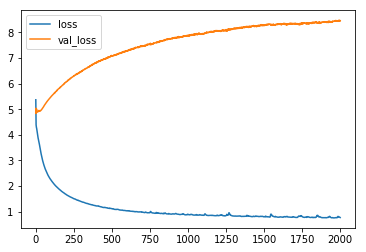

In [25]:
plt.plot(r.history['loss'],label = 'loss')
plt.plot(r.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

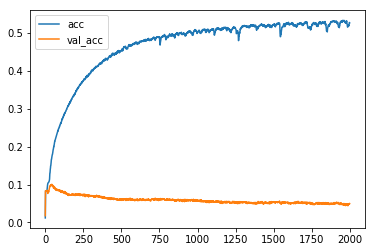

In [26]:
plt.plot(r.history['acc'],label = 'acc')
plt.plot(r.history['val_acc'],label = 'val_acc')
plt.legend()
plt.show()

In [27]:
# make a sampling model
input2 = Input(shape=(1,))
x = embedding_layeryeryeryer(input2)
x,h,c = lstm(x,initial_state =[initial_h,initial_c])
output2 = dense(x)
sampling_model = Model([input2,initial_h,initial_c],[output2,h,c])

In [28]:
idx2word = {v:k for k, v in word2idx.items()}

In [33]:
def sample_line():
    np_input = np.array([[ word2idx['<sos>'] ]])
    h = np.zeros((1,LATENT_DIM))
    c = np.zeros((1,LATENT_DIM))
    eos = word2idx['<eos>']
    
    # store the output here
    output_sentence = []
    for _ in range(max_sequence_length):
        o,h,c = sampling_model.predict([np_input,h,c])
    
        probs = o[0,0]
        if np.argmax(probs)==0:
            print('wtf')
        probs[0] = 0
        probs /= probs.sum()
        idx = np.random.choice(len(probs),p=probs)
        if idx == eos:
            break
        # acculate outout
        output_sentence.append(idx2word.get(idx,'<WTF %s>' % idx))
        
        # make the next input model
        np_input[0,0] = idx
    return ' '.join(output_sentence)

    

In [34]:
# generate a 4 line poem
while True:
    for _ in range(4):
        print(sample_line())
    ans = input("---generate another ?[Y/n]---")
    if ans and ans[0].lower().startswith('n'):\
        break
        

who used to live here. they were robinsons.
it left the family tree.'
brushing their chalky skull with chalky fingers,
and when i know.
---generate another ?[Y/n]---yes
our business first's up attic with her books.'
who may be whole again curtain elsewhere.'
to turn him round. he some boston voices.
by it as it,
---generate another ?[Y/n]---yes
and build the chimney clear from the ground.
he guessed they'd know what will heard of the attic. when they
a small skiff
i should feel easier if i thought what the trees grow getting
---generate another ?[Y/n]---y
mother folks mustn't talk.'
with one leg and themselves
they all them that the birch
and that'd be enough to see in the dark to say-
---generate another ?[Y/n]---y
the house was no one to pay for birth.
the way he did in it,
i don't remember if to the dark to say- makes of the
to turn or been mountain not your eyes. saying,
---generate another ?[Y/n]---y
nothing gold can stay.
but i vow we must be near the place from where
how shall w